In [357]:
%matplotlib inline

import sys
PATH = '/Users/francescogemignani/Desktop/fma-proj'
sys.path.insert(0, PATH) 
from fma_metadata import utils

# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Regression Libraries
import statsmodels.api as sm
from termcolor import colored as cl
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error




import warnings
warnings.filterwarnings('ignore')

## A) Import and Merge Dataset

In [358]:
echonest = utils.load("/Users/francescogemignani/Google Drive/DM2/_FMA/fma_metadata/echonest.csv")
tracks = utils.load("/Users/francescogemignani/Google Drive/DM2/_FMA/fma_metadata/tracks.csv")

In [359]:
echo_genres = echonest['echonest','audio_features'].merge(tracks['track'][['genre_top']],on='track_id')
echo_genres.head()

acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
2             0.416675      0.675894  0.634476          0.010628  0.177647   
3             0.374408      0.528643  0.817461          0.001851  0.105880   
5             0.043567      0.745566  0.701470          0.000697  0.373143   
10            0.951670      0.658179  0.924525          0.965427  0.115474   
134           0.452217      0.513238  0.560410          0.019443  0.096567   

          speechiness    tempo   valence genre_top  
track_id                                            
2            0.159310  165.922  0.576661   Hip-Hop  
3            0.461818  126.957  0.269240   Hip-Hop  
5            0.124595  100.260  0.621661   Hip-Hop  
10           0.032985  111.562  0.963590       Pop  
134          0.525519  114.290  0.894072   Hip-Hop

In [360]:
echo_genres['genre_top'].value_counts()

Rock                   3892
Electronic             2170
Hip-Hop                 910
Folk                    874
Old-Time / Historic     357
Pop                     346
Classical               265
Jazz                    241
International           133
Instrumental             84
Blues                    66
Experimental             17
Spoken                    0
Soul-RnB                  0
Easy Listening            0
Country                   0
Name: genre_top, dtype: int64

## B) Anomaly Detection
Execute Isolation forest on all echonest dataset

In [361]:
def echo_outliers_detector(gen): 
    echo = echo_genres[echo_genres['genre_top'].isin([gen])]
    genre = echo['genre_top']
    echo.drop('genre_top',axis=1,inplace=True)
    
    scaler = StandardScaler()
    scaled_df=scaler.fit_transform(echo)
    
    pca = PCA(7,random_state=42)
    pca.fit(scaled_df)
    pca_proj = pca.transform(scaled_df)
    df_pca = pd.DataFrame(pca_proj[:,:3], columns= ['pca1', 'pca2', 'pca3'])
    
    # transform data in an np.ndarray 
    X_pca = np.array(pca_proj) # pca 7 principal components
    X_fd= np.array(scaled_df)  #no dim reduction
    
    #isolation-forest sklearn version
    F0_sk = IsolationForest(random_state=42, n_estimators=300, contamination=0.05).fit(X_fd) 
    
    # score isolation forest - sklearn
    outliers_sk = F0_sk.predict(X_fd)
    
    # IsolationForest Sklearn
    echo['outlier_IF_sklearn'] = outliers_sk
    echo['outlier_IF_sklearn'] = echo['outlier_IF_sklearn'].apply(lambda x: 'inlier' if x==1 else 'outlier')
    
    # sklearn IF
    print(f"**** Anomaly detected for {gen}  *****'")
    print(echo['outlier_IF_sklearn'].value_counts())
    print()
    
    echo = echo[echo['outlier_IF_sklearn'] == 'inlier']
    echo.drop('outlier_IF_sklearn',axis=1,inplace=True)
    return echo

In [362]:
# Echonest genres anomaly free (without outlier_IF_sklearn and genre_top column)
echo_rock=echo_outliers_detector('Rock')
echo_electro=echo_outliers_detector('Electronic')
echo_hh=echo_outliers_detector('Hip-Hop')
echo_folk=echo_outliers_detector('Folk')
echo_old=echo_outliers_detector('Old-Time / Historic')
echo_pop=echo_outliers_detector('Pop')
echo_classic=echo_outliers_detector('Classical')
echo_jazz=echo_outliers_detector('Jazz')



**** Anomaly detected for Rock  *****'
inlier     3697
outlier     195
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Electronic  *****'
inlier     2061
outlier     109
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Hip-Hop  *****'
inlier     864
outlier     46
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Folk  *****'
inlier     830
outlier     44
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Old-Time / Historic  *****'
inlier     339
outlier     18
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Pop  *****'
inlier     328
outlier     18
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Classical  *****'
inlier     251
outlier     14
Name: outlier_IF_sklearn, dtype: int64

**** Anomaly detected for Jazz  *****'
inlier     229
outlier     12
Name: outlier_IF_sklearn, dtype: int64



## C) Linear Relationships
#### Echonest Correlations
Make a echonest sub-selection for each genre. In particular, we've selected genres that occours the most. For each echo_genre dataset we search some positive or negative linear relationship between echonest features.

#### Rock

Text(0.5, 1.0, 'Correlation Matrix Echonest Rock')

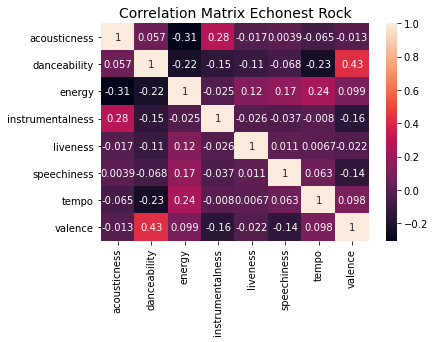

In [363]:
#Check Rock correlation
sns.heatmap(echo_rock.corr(),annot=True)
plt.title("Correlation Matrix Echonest Rock", fontsize=14)

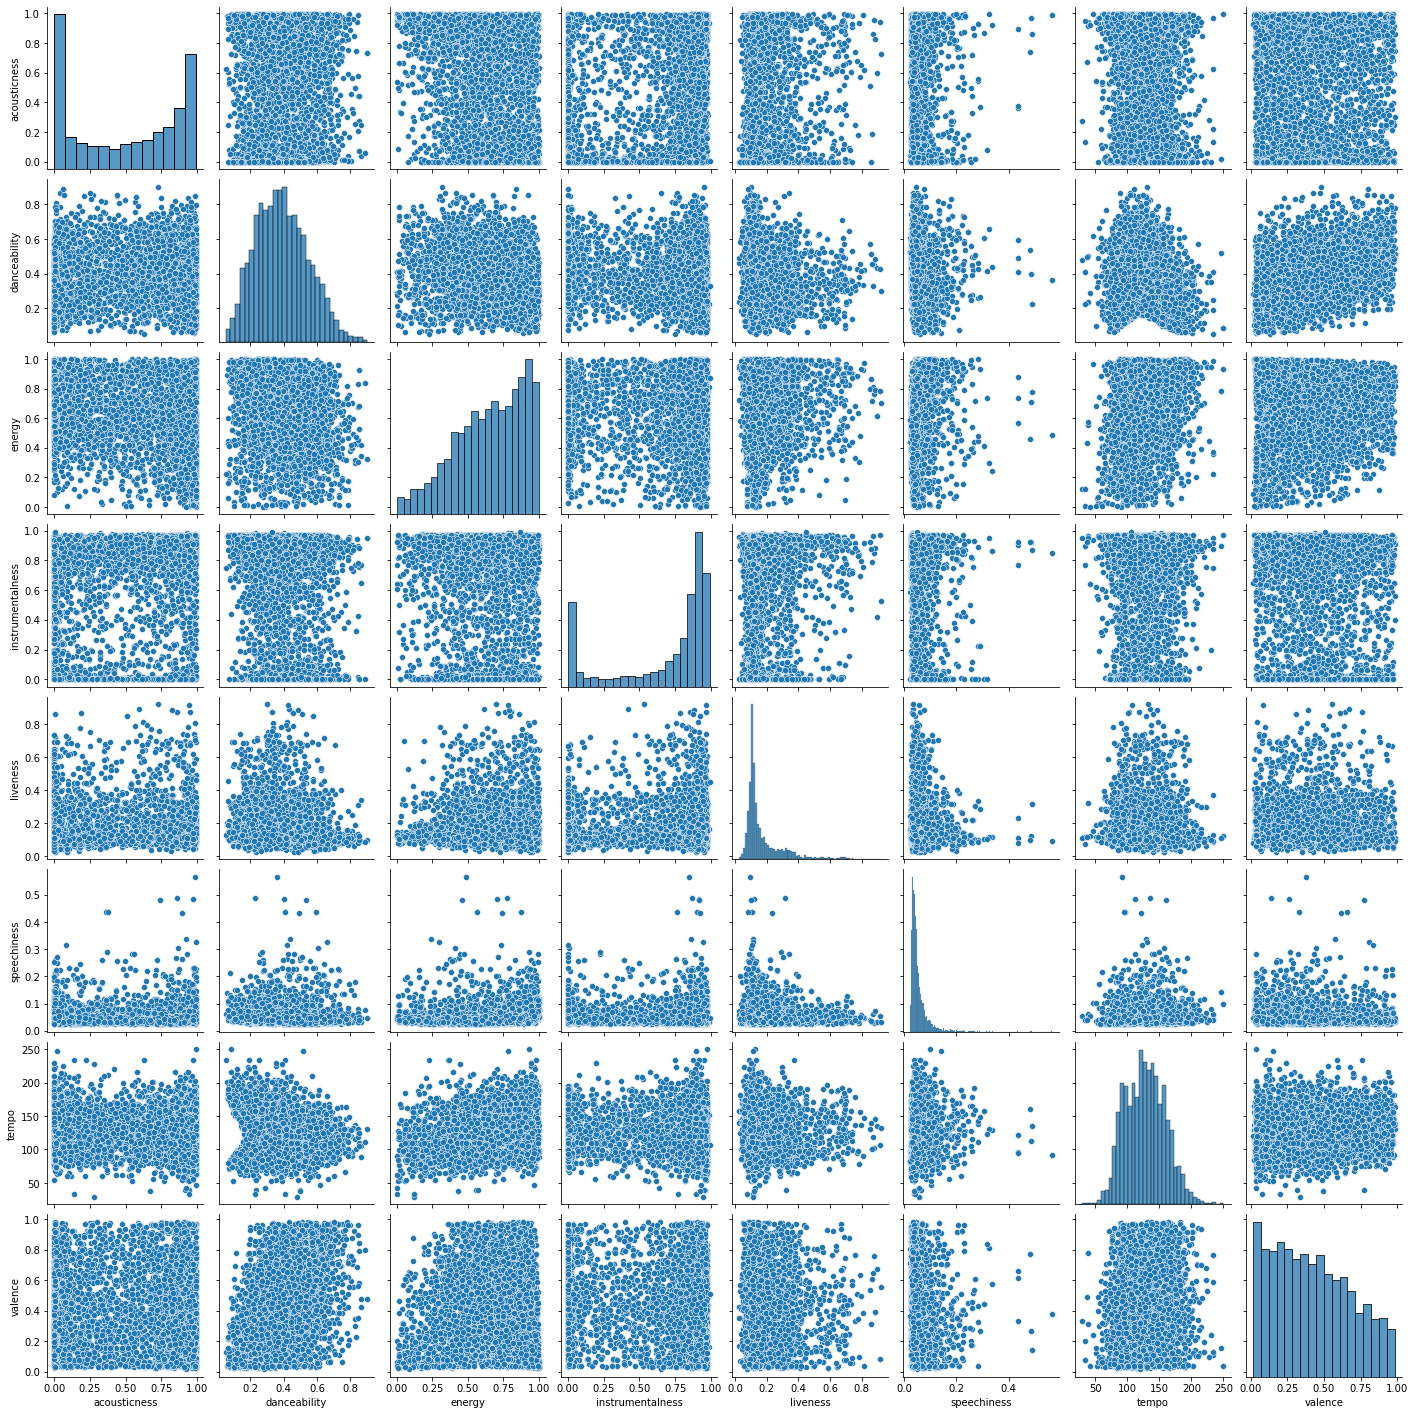

In [364]:
sns.pairplot(echo_rock)

#### Electronic

Text(0.5, 1.0, 'Correlation Matrix Echonest Electronic')

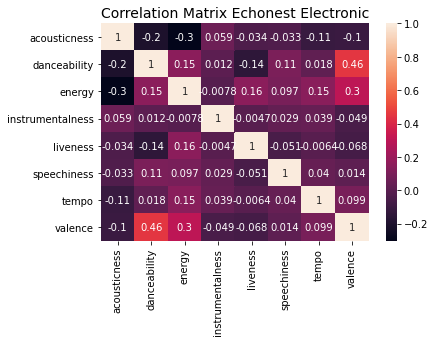

In [365]:
#Check Electronic correlation
sns.heatmap(echo_electro.corr(),annot=True)
plt.title("Correlation Matrix Echonest Electronic", fontsize=14)

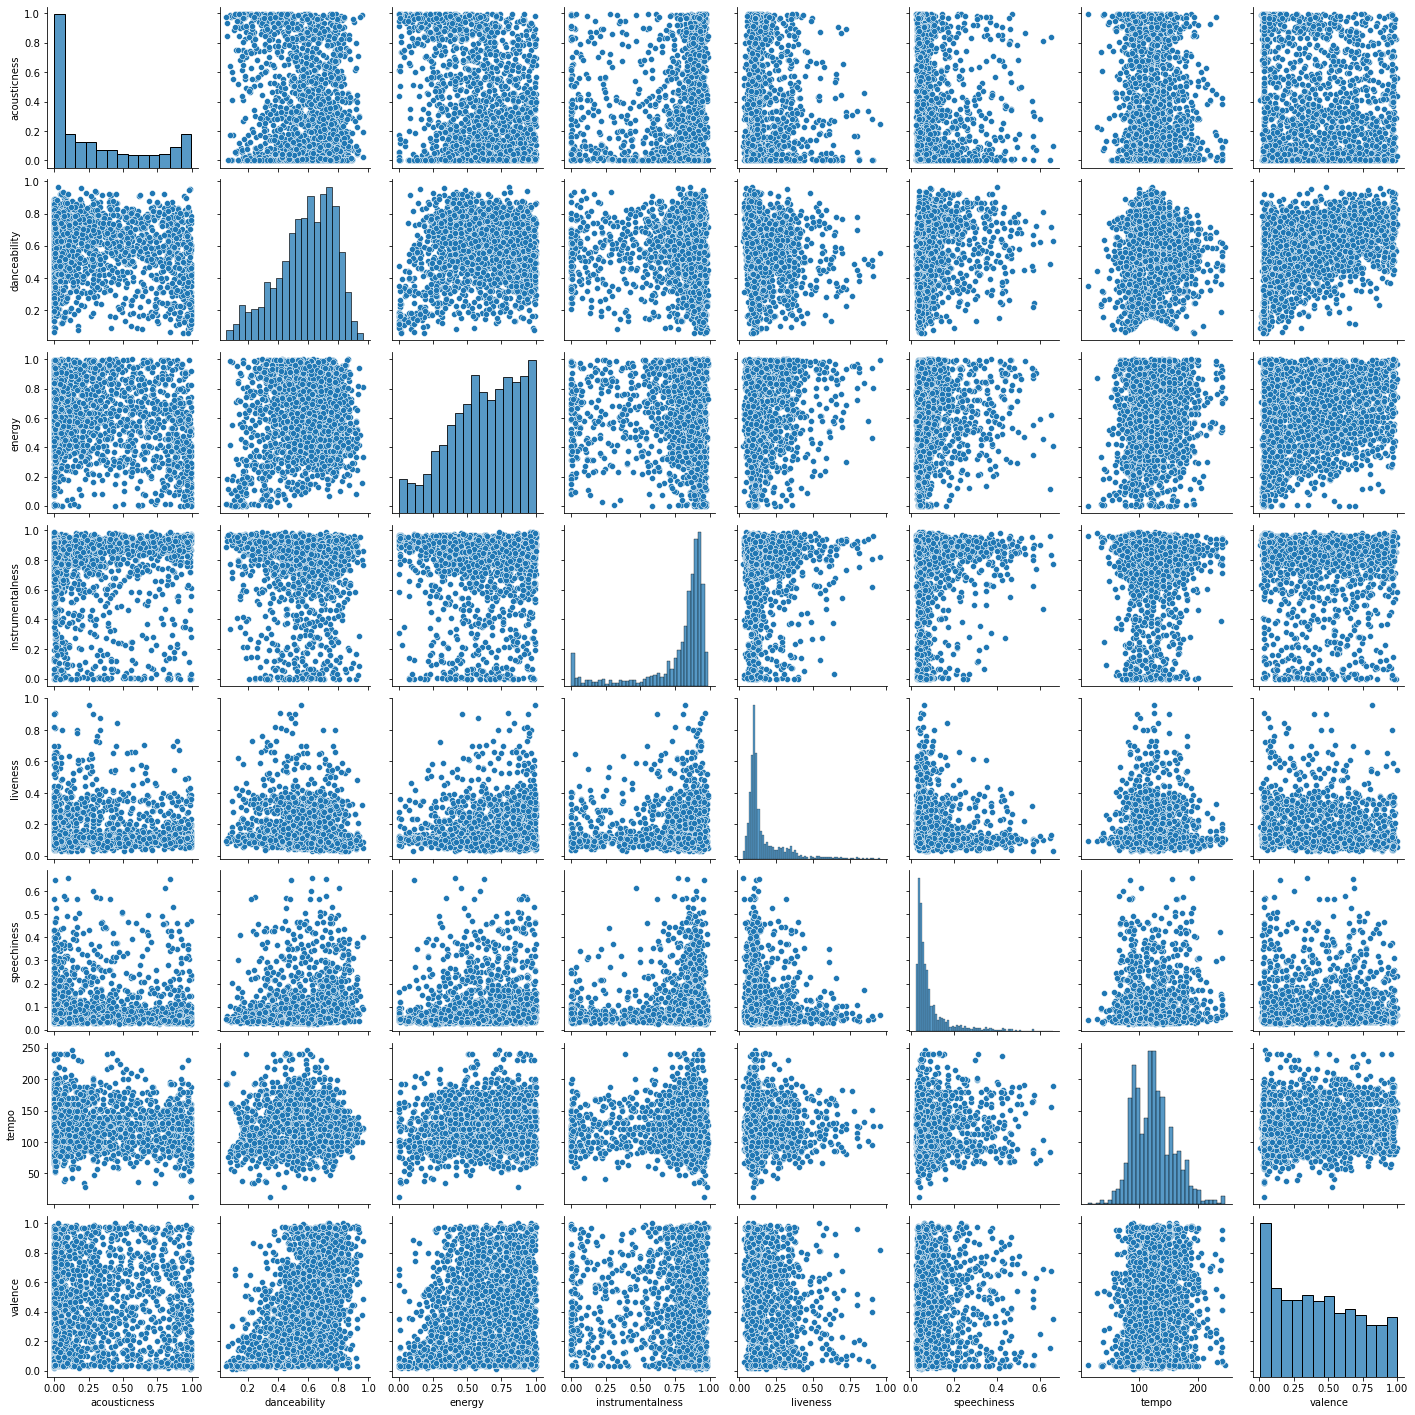

In [366]:
sns.pairplot(echo_electro)

#### Hip-Hop

Text(0.5, 1.0, 'Correlation Matrix Echonest Hip-Hop')

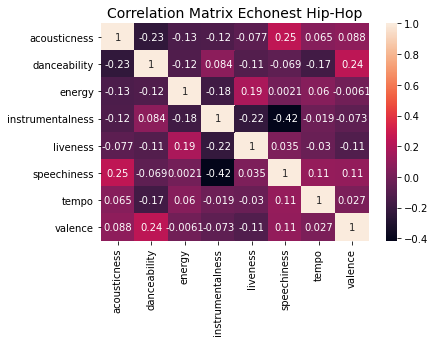

In [367]:
#Check Hip-Hop correlation
sns.heatmap(echo_hh.corr(),annot=True)
plt.title("Correlation Matrix Echonest Hip-Hop", fontsize=14)

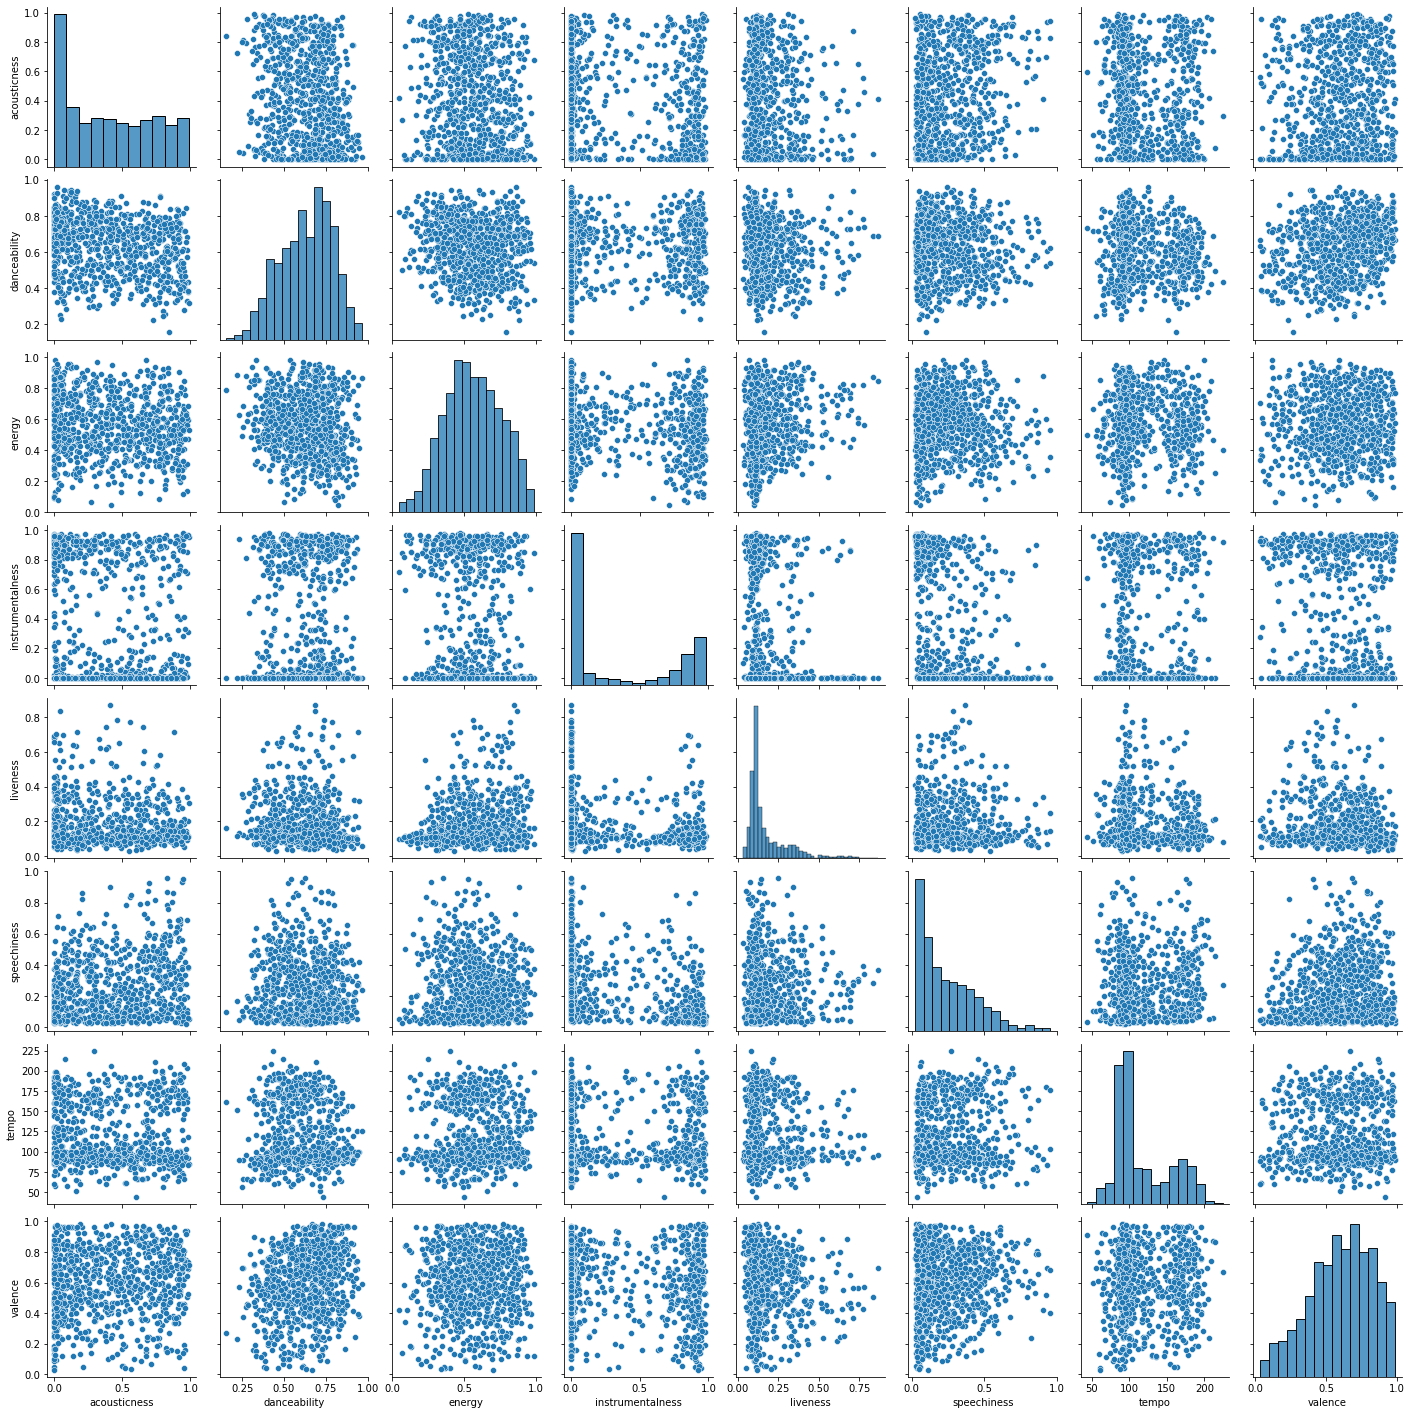

In [368]:
sns.pairplot(echo_hh)

#### Folk

Text(0.5, 1.0, 'Correlation Matrix Echonest Folk')

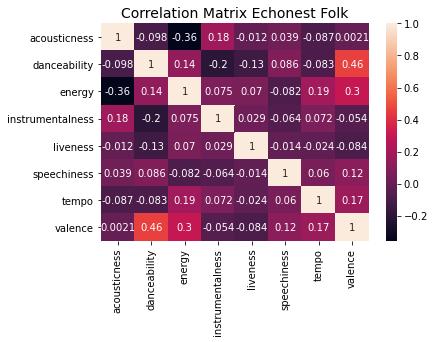

In [369]:
#Check Folk correlation
sns.heatmap(echo_folk.corr(),annot=True)
plt.title("Correlation Matrix Echonest Folk", fontsize=14)

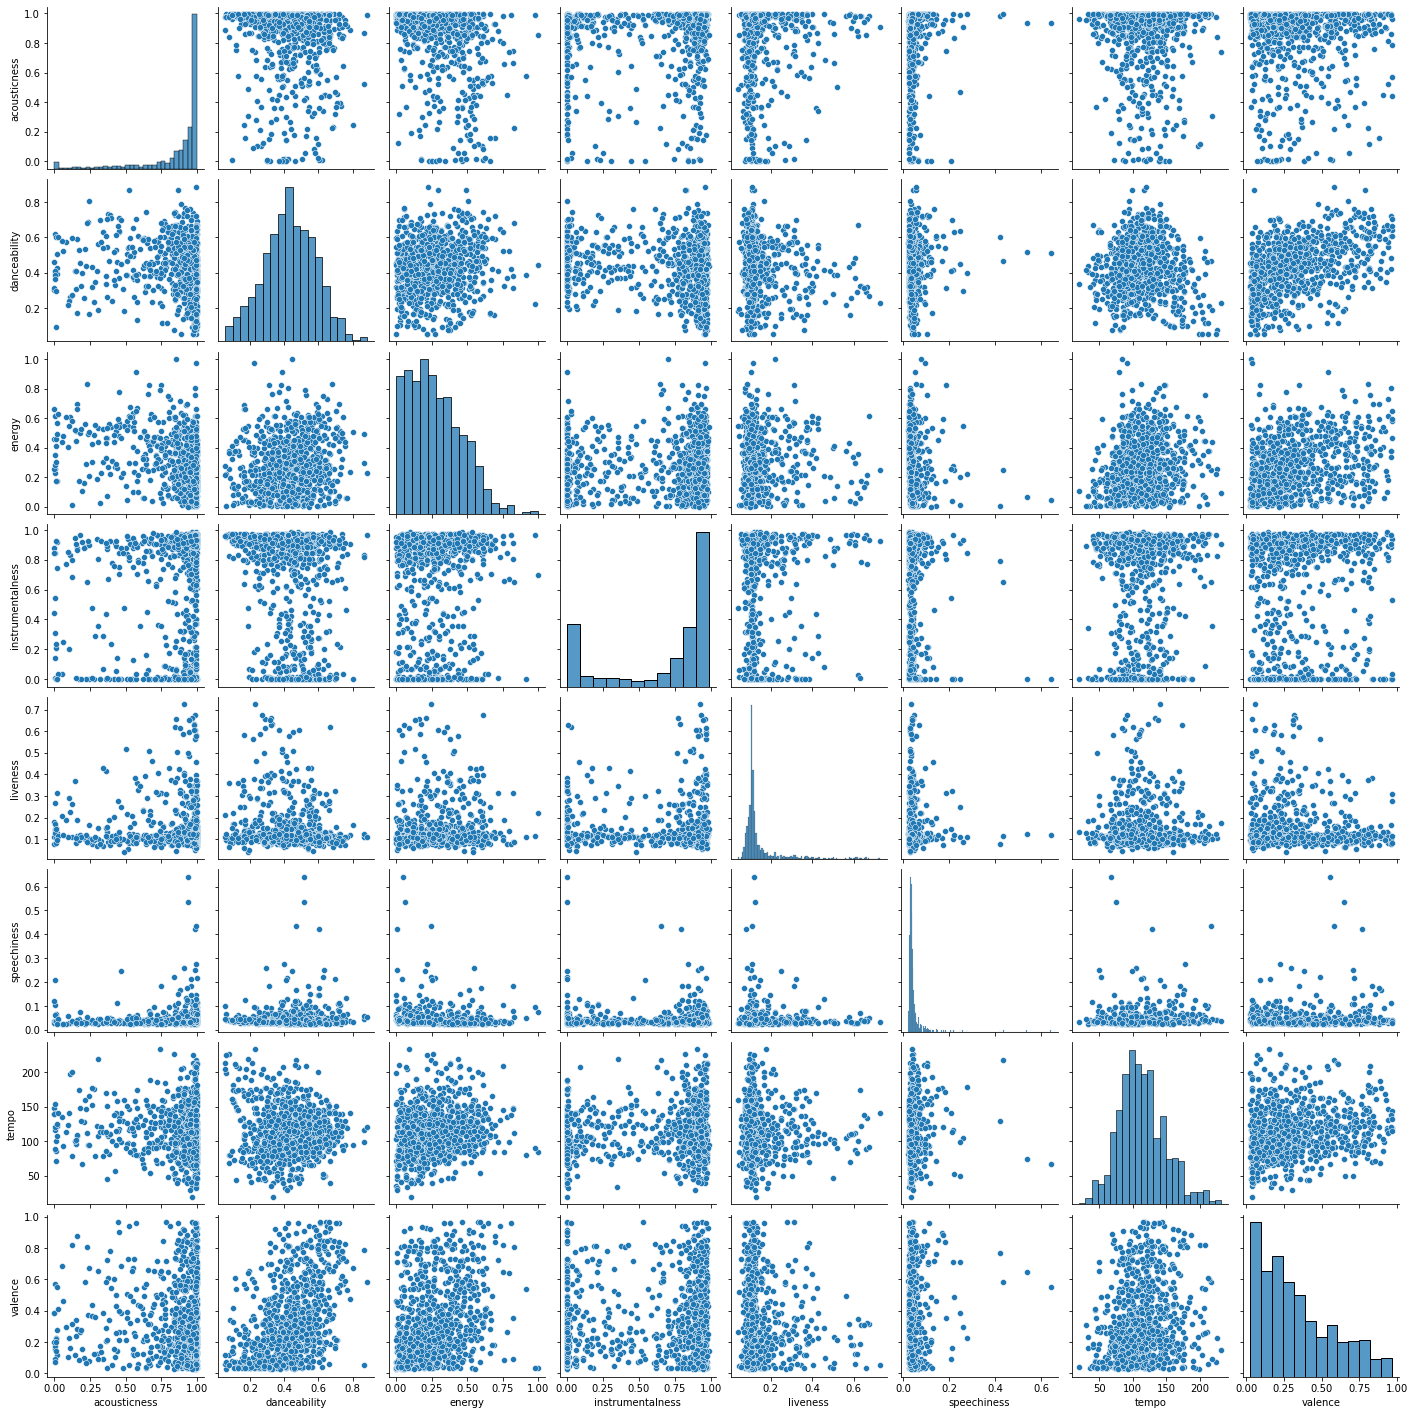

In [370]:
sns.pairplot(echo_folk)

#### Old Time / Historic

Text(0.5, 1.0, 'Correlation Matrix Echonest Old-Time/Historical')

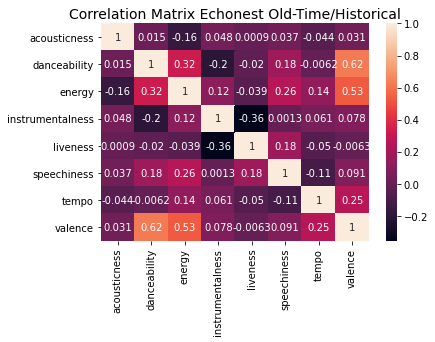

In [371]:
#Check Old-Time / Historic correlation
sns.heatmap(echo_old.corr(),annot=True)
plt.title("Correlation Matrix Echonest Old-Time/Historical", fontsize=14)

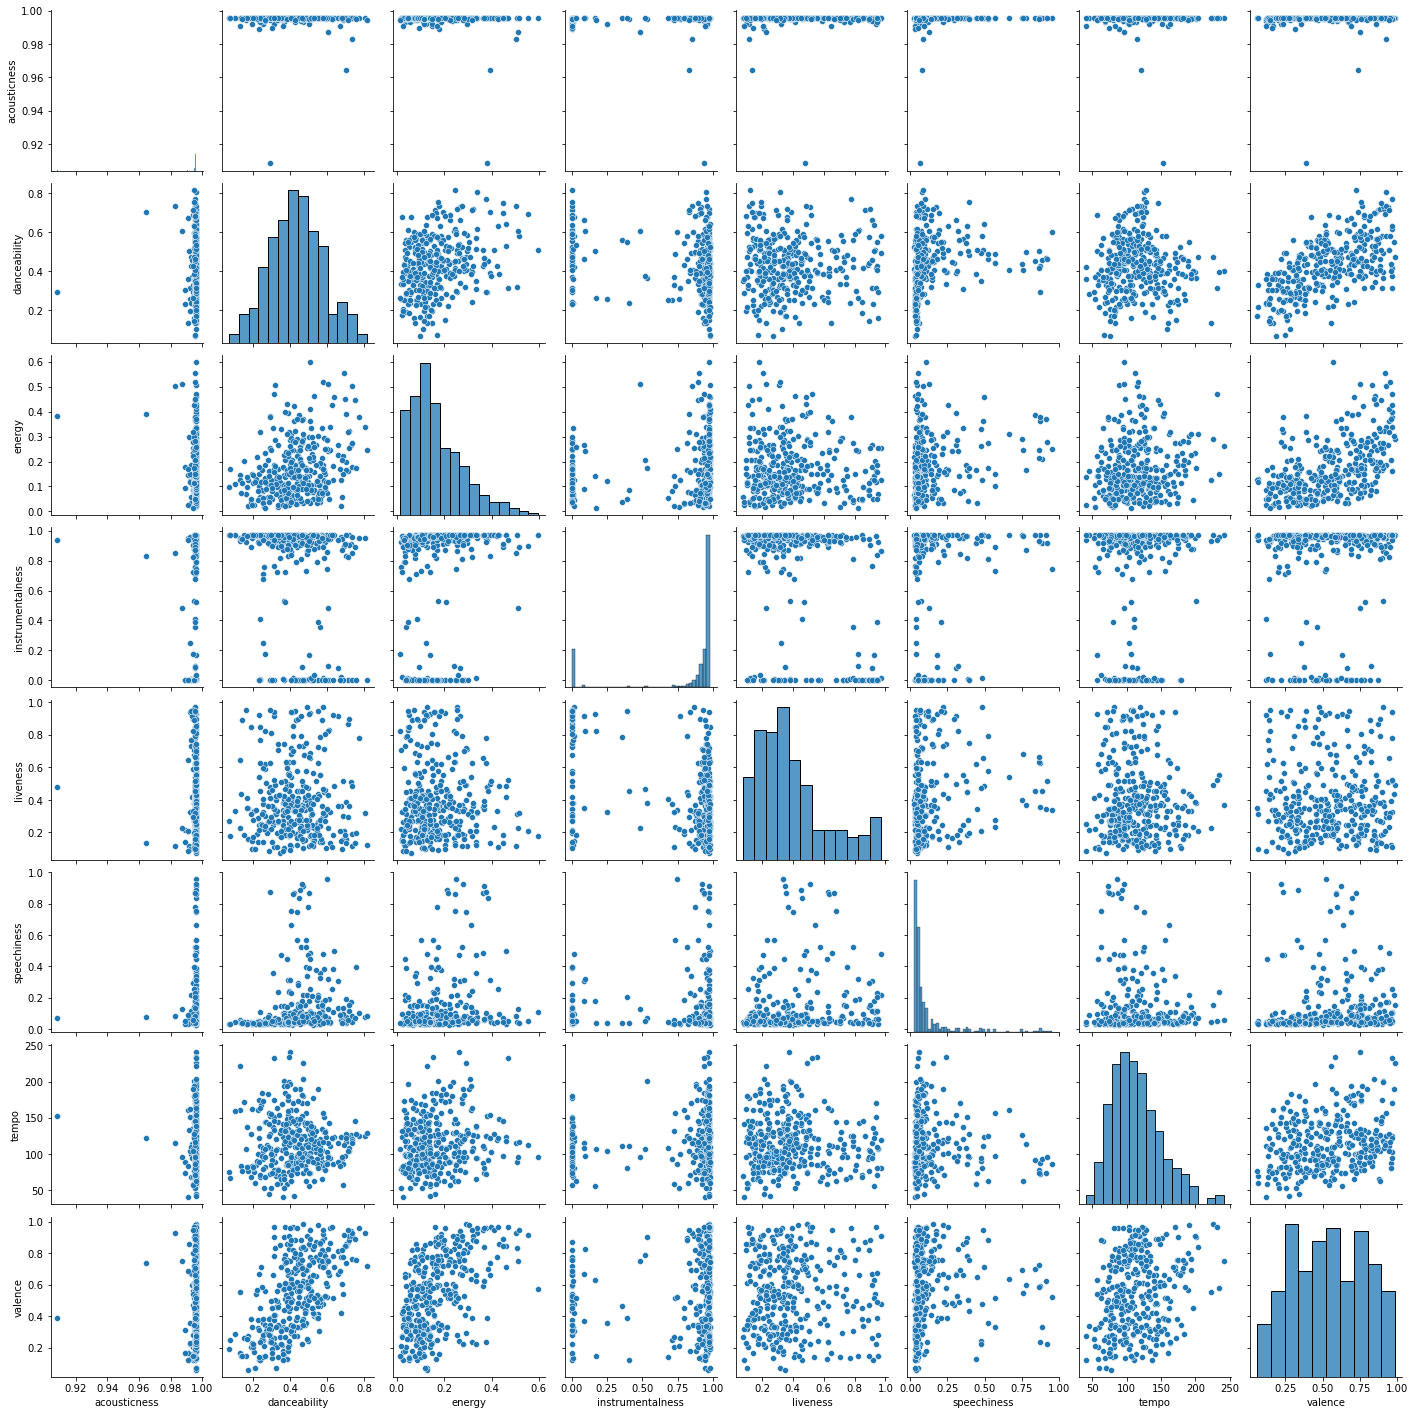

In [372]:
sns.pairplot(echo_old)

<AxesSubplot:xlabel='valence', ylabel='danceability'>

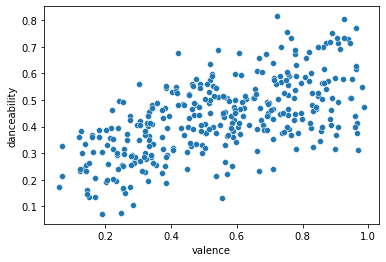

In [373]:
# Best correlation with dependent variable valence and danceability with genre selected
sns.scatterplot(data=echo_old, y='danceability', x="valence")

#### Pop

Text(0.5, 1.0, 'Correlation Matrix Echonest Pop')

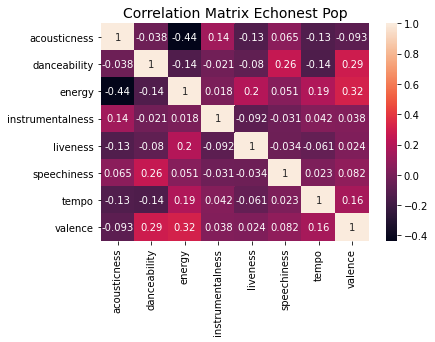

In [374]:
#Check Pop correlation
sns.heatmap(echo_pop.corr(),annot=True)
plt.title("Correlation Matrix Echonest Pop", fontsize=14)

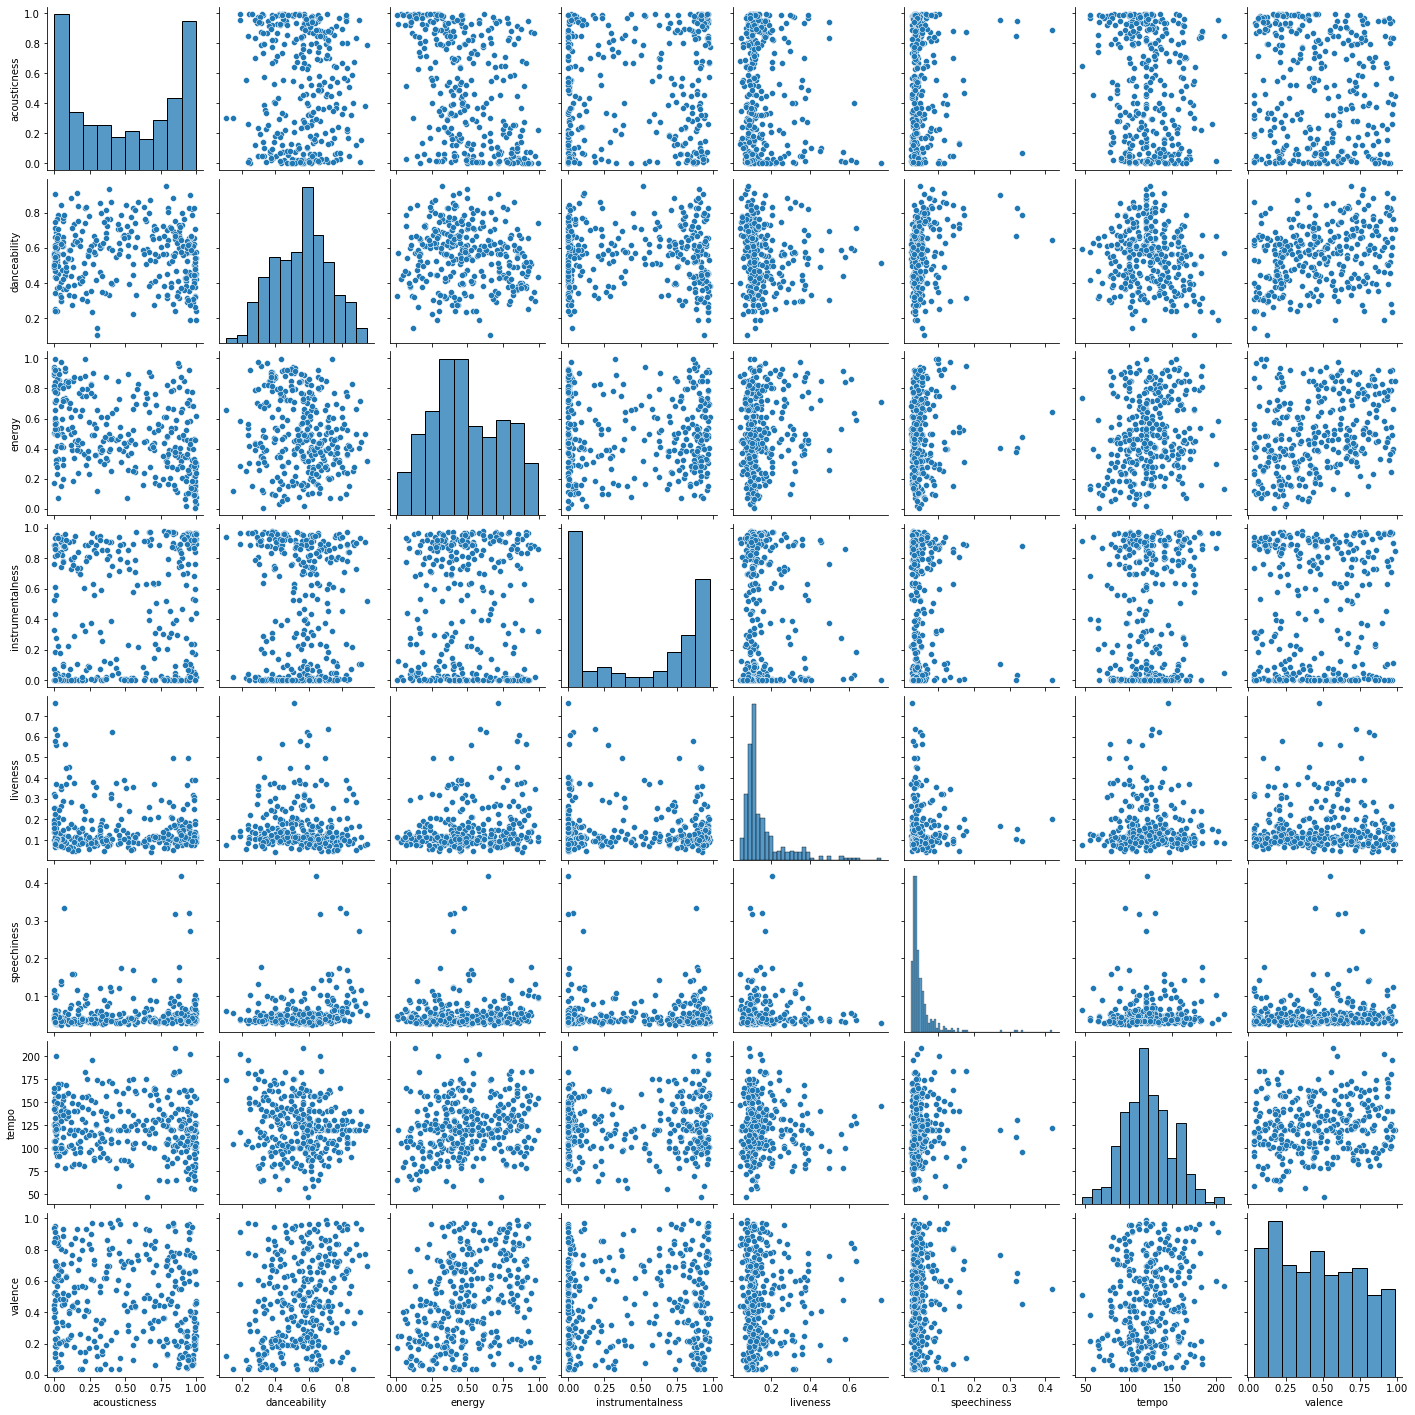

In [375]:
sns.pairplot(echo_pop)

#### Classical

Text(0.5, 1.0, 'Correlation Matrix Echonest Classical')

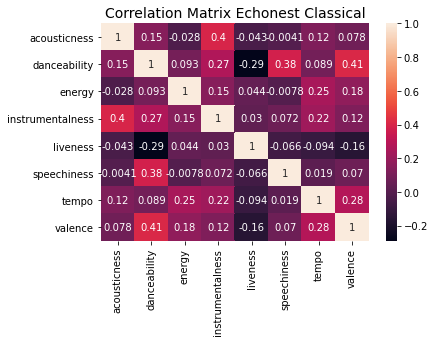

In [376]:
#Check Classical correlation
sns.heatmap(echo_classic.corr(),annot=True)
plt.title("Correlation Matrix Echonest Classical", fontsize=14)

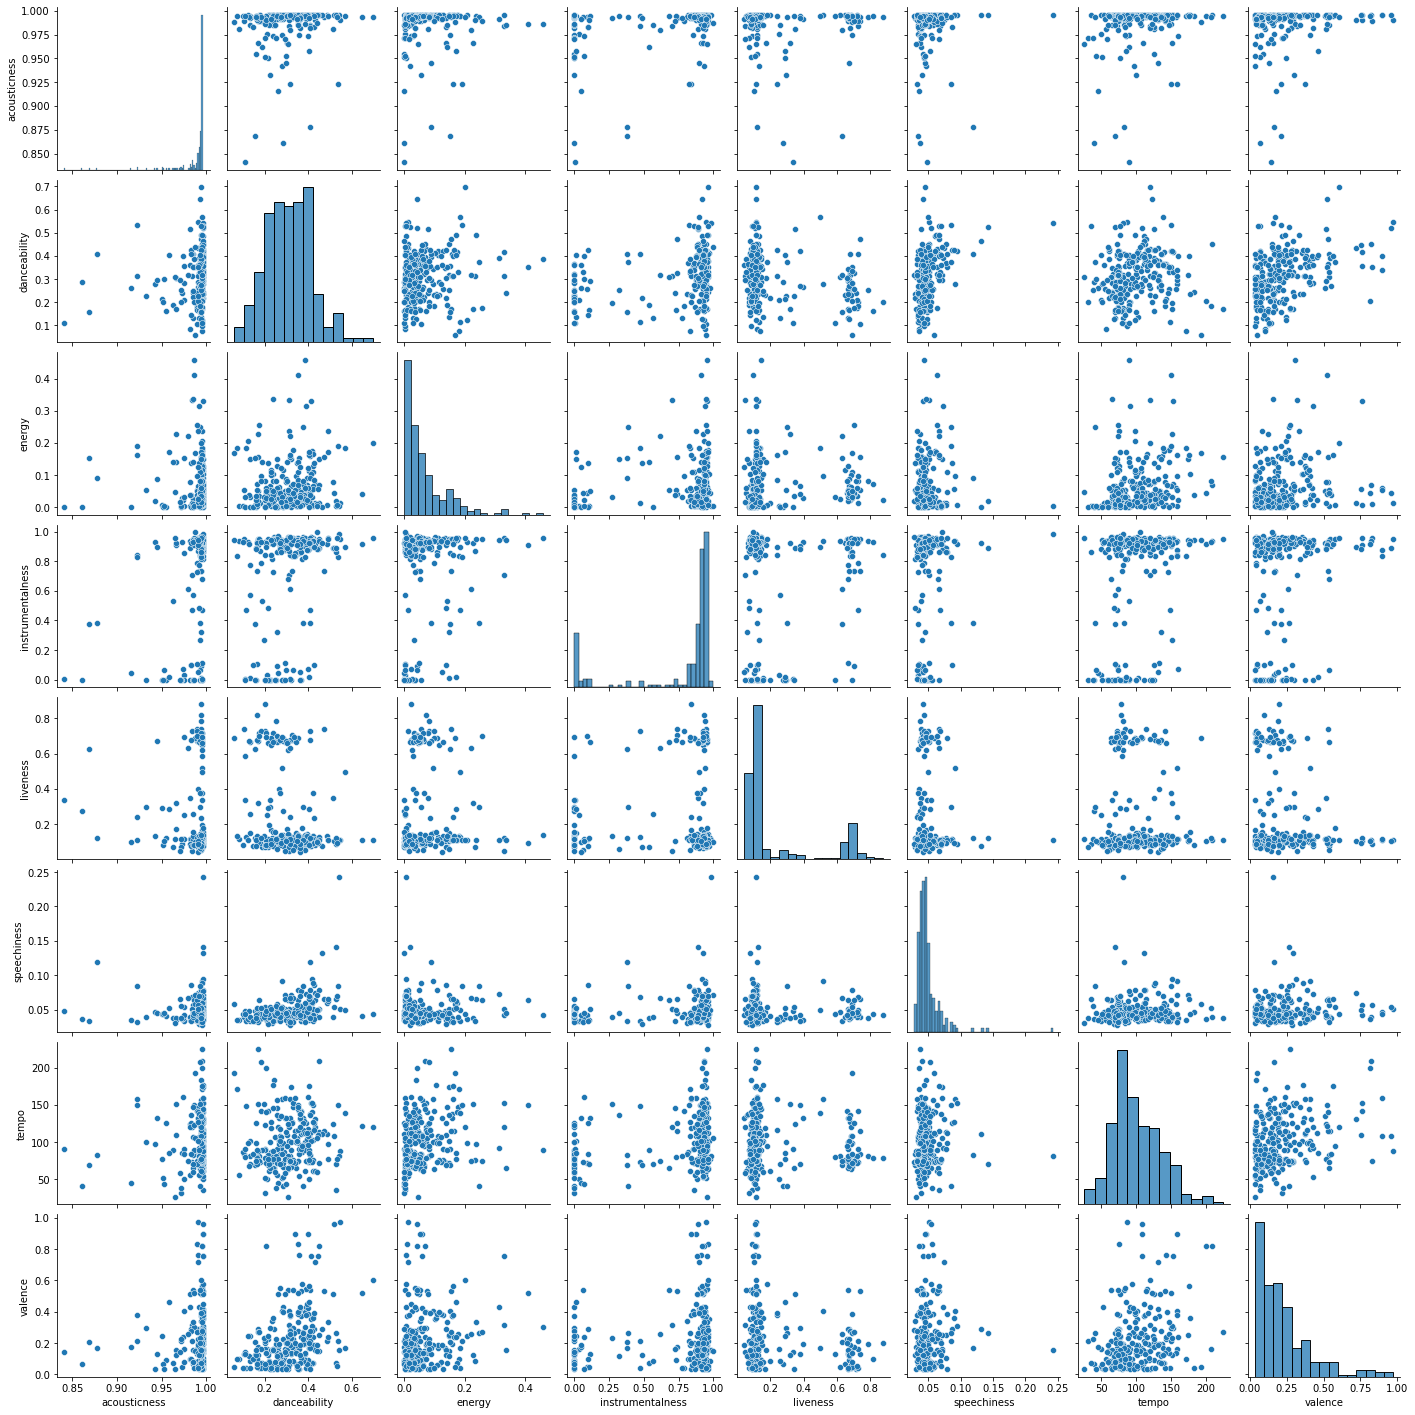

In [377]:
sns.pairplot(echo_classic)

#### Jazz

Text(0.5, 1.0, 'Correlation Matrix Echonest Jazz')

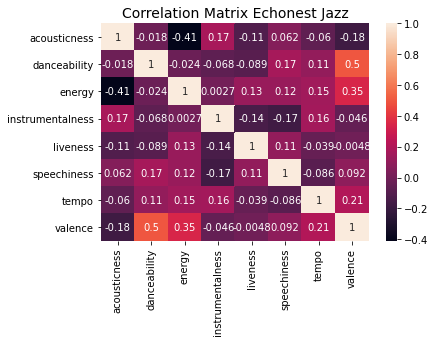

In [378]:
#Check Jazz correlation
sns.heatmap(echo_jazz.corr(),annot=True)
plt.title("Correlation Matrix Echonest Jazz", fontsize=14)

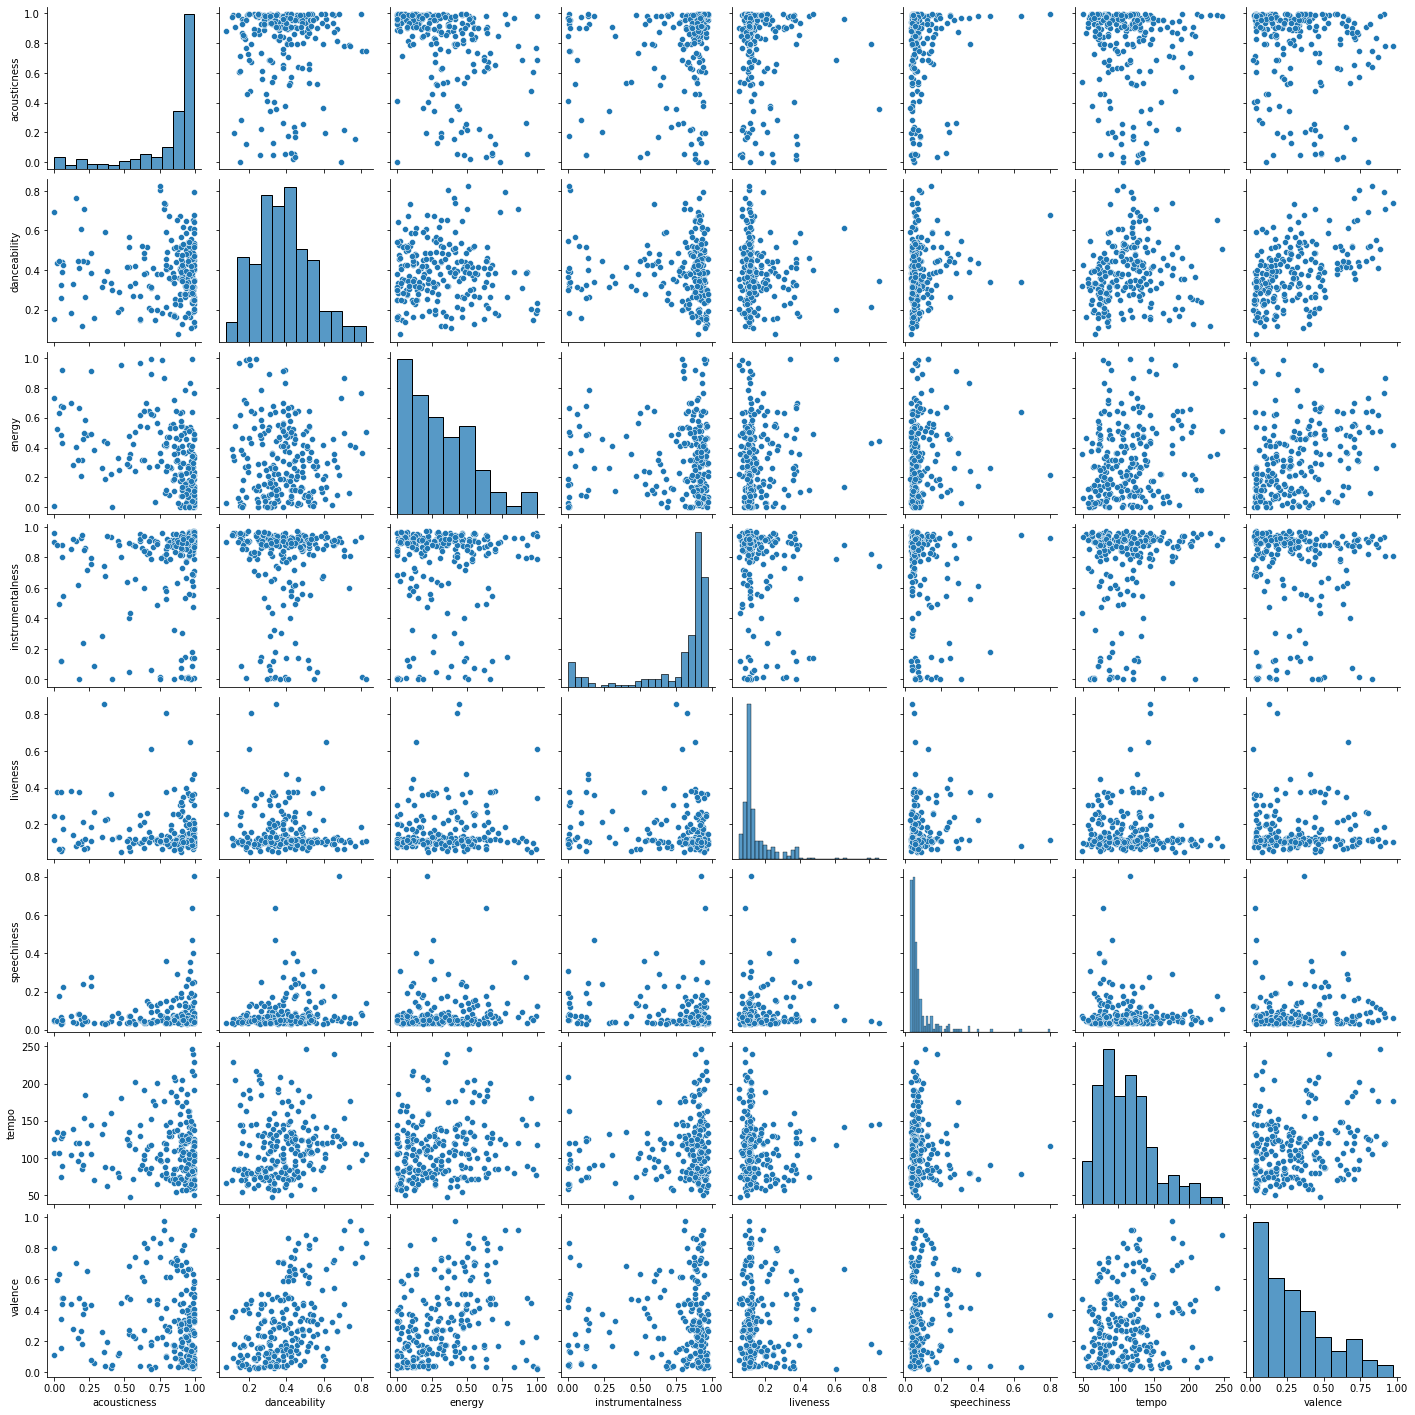

In [379]:
sns.pairplot(echo_jazz)

## D) Simple Linear Regression 
in this case we've one independent variable and a dependent variable

In [476]:
# echonest genre selected for regression
ECHO_GENRE = echo_old 
GENRE = 'Historical'

# continuous dependent variable
DEP_VAR = 'danceability'

# continuous independent variable
INDEP_VAR_1 = 'valence'

#others continuous independent variables (MLR)'
INDEP_VAR_2 = 'energy'
INDEP_VAR_3 = 'speechiness'
INDEP_VAR_4 = 'acousticness'

### D.1) Best Linear Relationship
The best correlation we found is 0.62: between x=valence y=danceability in echonest old / historical genre.
P(danceability|valence). In general, we saw that for each genre danceability and valence are well correlated.

Text(0.5, 0, 'valence')

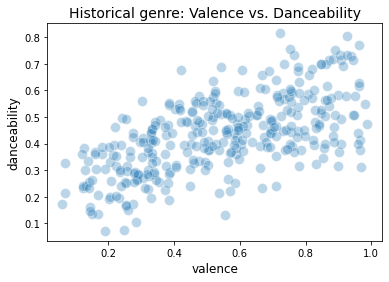

In [381]:
plt.scatter(y = DEP_VAR, x = INDEP_VAR_1, data = ECHO_GENRE, s = 100, alpha = 0.3, edgecolor = 'white')
plt.title(GENRE+' genre: Valence vs. Danceability', fontsize = 14)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

### D.2) Attributes
To build a Simple Linear Regression (SLR) model, we must have an independent variable and a dependent variable. For our SLR model, we are going to take Valence as the independent variable and Danceability as the dependent variable.

In [382]:
# independent variable
X_var = ECHO_GENRE[[INDEP_VAR_1]]

#dependent variable
y_var = ECHO_GENRE[[DEP_VAR]]

In [383]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_var, y_var, test_size=0.30 ,random_state=0)

### D.3) SLR model with Statsmodels
In this case we build a simple linear regression model which use statsmodel

In [384]:
# Ordinary Least Square
slr_model = sm.OLS(y_var,X_var)
slr_reg = slr_model.fit()

In [385]:
print( cl( slr_reg.summary(),attrs = ['bold']) )

                                 OLS Regression Results                                
Dep. Variable:           danceability   R-squared (uncentered):                   0.897
Model:                            OLS   Adj. R-squared (uncentered):              0.897
Method:                 Least Squares   F-statistic:                              2954.
Date:                Wed, 31 Mar 2021   Prob (F-statistic):                   3.91e-169
Time:                        14:20:25   Log-Likelihood:                          171.27
No. Observations:                 339   AIC:                                     -340.5
Df Residuals:                     338   BIC:                                     -336.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### D.4) SLR model with Scikit-learn

In [386]:
#Function to get cross validation score R2
def get_cv_scores(model,X_train,y_train):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')
    
    print('CV Mean (R2): ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [387]:
# build the model
slr = LinearRegression()
slr.fit(X,y)
y_pred = slr.predict(X_test)

In [388]:
#Evaluations
print("***Cross Validation R2 score - Training Data***")
get_cv_scores(slr,X,y) #R2 cv on training data

print("***Cross Validation R2 score - Test Data***")
get_cv_scores(slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Training Data***
CV Mean (R2):  0.3430711982261586
STD:  0.06427393105855016


***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.2697797527561073
STD:  0.21726334235497585


***Scores (no cv) on Test Data***
R2: 0.370
MSE: 0.013
MAE: 0.091


In [389]:
# Compute hypotesis weight and bias

# Y = wX+B where X=valence and Y=danceability
slr_slope = slr.coef_ # weight: w
slr_intercept = slr.intercept_ # bias B
print('Coefficients: \n', slr_slope)
print('Intercept: \n', slr_intercept)

Coefficients: 
 [[0.37636484]]
Intercept: 
 [0.22887615]


Text(0.5, 0, 'valence')

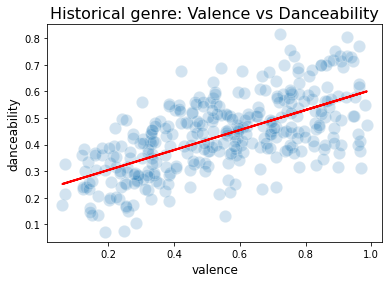

In [390]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = ECHO_GENRE, s = 150, alpha = 0.2, edgecolor = 'white')
plt.plot(ECHO_GENRE[INDEP_VAR_1], slr_slope*ECHO_GENRE[[INDEP_VAR_1]] + slr_intercept, color = 'r', linewidth = 2)
plt.title(GENRE+' genre: Valence vs Danceability', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

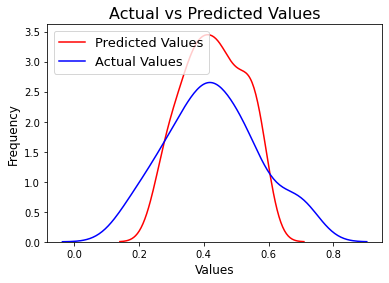

In [391]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### D.5) Lasso Simple Linear Regression (L1 Regularization) 

#### D.5.1) Evaluation with no alpha optimization

In [392]:
lasso_slr = Lasso(alpha=1)
lasso_slr.fit(X,y)
y_pred = lasso_slr.predict(X_test)

In [393]:
#Evaluations

print("***Cross Validation R2 score - Training Data***")
get_cv_scores(lasso_slr,X,y) #R2 cv on training data

print("***Cross Validation R2 score - Test Data***")
get_cv_scores(lasso_slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Training Data***
CV Mean (R2):  -0.0521298407360673
STD:  0.050759031646760745


***Cross Validation R2 score - Test Data***
CV Mean (R2):  -0.1480978032814897
STD:  0.1761370685627478


***Scores (no cv) on Test Data***
R2: -0.003
MSE: 0.020
MAE: 0.114


In [394]:
lasso_slr_slope = lasso_slr.coef_ 
lasso_slr_intercept = lasso_slr.intercept_ 
print('Coefficients: \n', lasso_slr.coef_)
print('Intercept: \n', lasso_slr.intercept_)

Coefficients: 
 [0.]
Intercept: 
 [0.43493654]


Text(0.5, 0, 'valence')

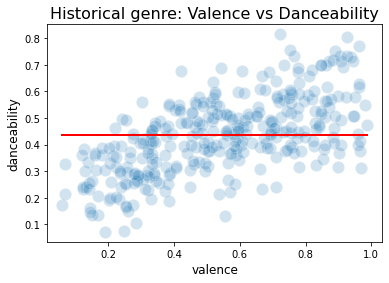

In [395]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = ECHO_GENRE, s = 150, alpha = 0.2, edgecolor = 'white')
plt.plot(ECHO_GENRE[INDEP_VAR_1], lasso_slr_slope*ECHO_GENRE[[INDEP_VAR_1]] + lasso_slr_intercept, color = 'r', linewidth = 2)
plt.title(GENRE+' genre: Valence vs Danceability', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)


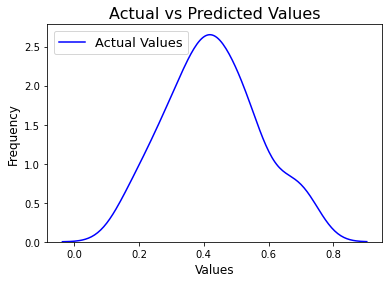

In [396]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

#### D.5.2)  Evaluation with alpha optimization
We've used GridSearch to find the optimal alpha value

In [397]:
# find optimal alpha with grid search 
alpha = [0.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)

In [398]:
lasso_slr = Lasso()
grid = GridSearchCV(estimator=lasso_slr, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.6s finished


In [399]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.34340178188437787
Best Params:  {'alpha': 0.001}


#### Retrain the lasso regression with optimal value of alpha

In [400]:
lasso_slr = Lasso(alpha=0.001)
lasso_slr.fit(X,y)
y_pred = lasso_slr.predict(X_test)

In [401]:
#Evaluations
print("***Cross Validation R2 score - Training Data***")
get_cv_scores(lasso_slr,X,y) #R2 cv on training data

print("***Cross Validation R2 score - Test Data***")
get_cv_scores(lasso_slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Training Data***
CV Mean (R2):  0.34340178188437787
STD:  0.059194191098214416


***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.26846123119410137
STD:  0.21011355020809244


***Scores (no cv) on Test Data***
R2: 0.372
MSE: 0.013
MAE: 0.091


In [402]:
lasso_slr_slope = lasso_slr.coef_ 
lasso_slr_intercept = lasso_slr.intercept_ 
print('Coefficients: \n', lasso_slr.coef_)
print('Intercept: \n', lasso_slr.intercept_)

Coefficients: 
 [0.35857517]
Intercept: 
 [0.23861603]


Text(0.5, 0, 'valence')

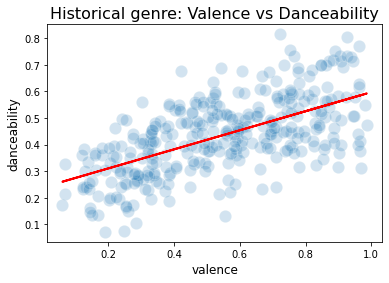

In [403]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = ECHO_GENRE, s = 150, alpha = 0.2, edgecolor = 'white')
plt.plot(ECHO_GENRE[INDEP_VAR_1], lasso_slr_slope*ECHO_GENRE[[INDEP_VAR_1]] + lasso_slr_intercept, color = 'r', linewidth = 2)
plt.title(GENRE+' genre: Valence vs Danceability', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)


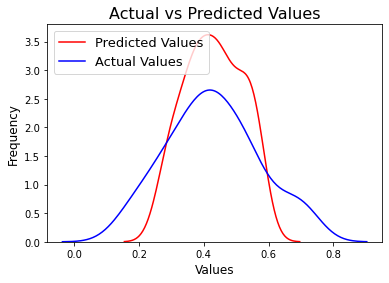

In [404]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### D.6) Ridge Simple Linear Regression (L2 Regularization)

#### D.6.1) Evaluation with no alpha optimization

In [405]:
ridge_slr = Ridge(alpha=1)
ridge_slr.fit(X,y)
y_pred = ridge_slr.predict(X_test)

In [406]:
#Evaluations without grid search

print("***Cross Validation R2 score - Training Data***")
get_cv_scores(ridge_slr,X,y) #R2 cv on training data

print("***Cross Validation R2 score - Test Data***")
get_cv_scores(ridge_slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Training Data***
CV Mean (R2):  0.34283207587336834
STD:  0.055572742447321605


***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.2585129234368331
STD:  0.1926080091812945


***Scores (no cv) on Test Data***
R2: 0.372
MSE: 0.013
MAE: 0.091


In [407]:
ridge_slr_slope = ridge_slr.coef_ 
ridge_slr_intercept = ridge_slr.intercept_
print('Coefficients: \n', ridge_slr.coef_)
print('Intercept: \n', ridge_slr.intercept_)

Coefficients: 
 [[0.35008667]]
Intercept: 
 [0.24326349]


Text(0.5, 0, 'valence')

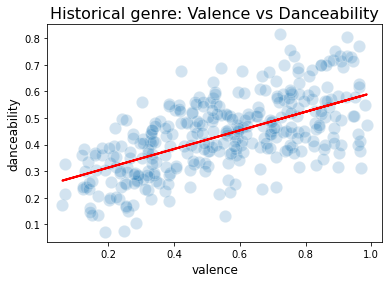

In [408]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = ECHO_GENRE, s = 150, alpha = 0.2, edgecolor = 'white')
plt.plot(ECHO_GENRE[INDEP_VAR_1], ridge_slr_slope*ECHO_GENRE[[INDEP_VAR_1]] + ridge_slr_intercept, color = 'r', linewidth = 2)
plt.title(GENRE+' genre: Valence vs Danceability', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)


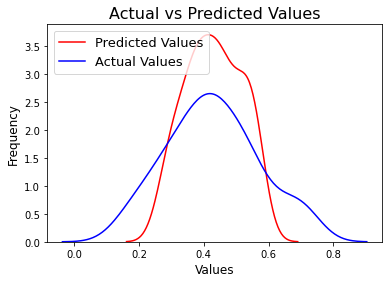

In [409]:
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

#### D.6.2) Evaluation optimizing alpha value
We've used GridSearch to find the optimal alpha value

In [410]:
# find optimal alpha with grid search
alpha = [0.00001,0.0001,0.001, 0.01,0.05, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)

In [411]:
ridge_slr = Ridge()
grid = GridSearchCV(estimator=ridge_slr, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


In [412]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.3433505445949021
Best Params:  {'alpha': 0.1}


#### Retrain ridge regression with optimal value of alpha

In [413]:
ridge_slr = Ridge(alpha=0.1)
ridge_slr.fit(X,y)
y_pred = ridge_slr.predict(X_test)

In [414]:
#Evaluations
print("***Cross Validation R2 score - Training Data***")
get_cv_scores(ridge_slr,X,y) #R2 cv on training data

print("***Cross Validation R2 score - Test Data***")
get_cv_scores(ridge_slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Training Data***
CV Mean (R2):  0.3433505445949021
STD:  0.06319764356091778


***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.26974352436131
STD:  0.2142820363020914


***Scores (no cv) on Test Data***
R2: 0.370
MSE: 0.013
MAE: 0.091


In [415]:
ridge_slr_slope = ridge_slr.coef_ 
ridge_slr_intercept = ridge_slr.intercept_
print('Coefficients: \n', ridge_slr.coef_)
print('Intercept: \n', ridge_slr.intercept_)

Coefficients: 
 [[0.37356082]]
Intercept: 
 [0.23041136]


Text(0.5, 0, 'valence')

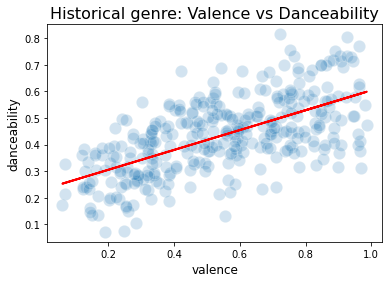

In [416]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = ECHO_GENRE, s = 150, alpha = 0.2, edgecolor = 'white')
plt.plot(ECHO_GENRE[INDEP_VAR_1], ridge_slr_slope*ECHO_GENRE[[INDEP_VAR_1]] + ridge_slr_intercept, color = 'r', linewidth = 2)
plt.title(GENRE+' genre: Valence vs Danceability', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)


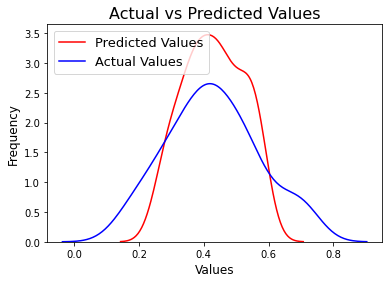

In [417]:
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

## E) Multivariate Linear Regression: MLR
In this case we have more than one independent variable and a dependent variable. 

### E.1) Attributes
To build a Multivariate Linear Regression (MLR) model, we selected two indipendents variables which the higher correlation with danceability (always in historical genre). Its are Energy and Valence, rispectivetly 0.32 and 0.62.

In [477]:
# independent variables
X_var = ECHO_GENRE[[INDEP_VAR_1,INDEP_VAR_2,INDEP_VAR_3,INDEP_VAR_4]]

#dependent variable
y_var = ECHO_GENRE[[DEP_VAR]]

In [478]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_var, y_var, test_size=0.30 ,random_state=0)

### E.2) MLR simple model

In [479]:
# build the model (same as before)
mlr = LinearRegression()
mlr.fit(X,y)
y_pred = mlr.predict(X_test)

In [480]:
#Evaluations
print("***Cross Validation R2 score - Training Data***")
get_cv_scores(mlr,X,y) #R2 cv on training data

print("***Cross Validation R2 score - Test Data***")
get_cv_scores(mlr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Training Data***
CV Mean (R2):  0.361267687512698
STD:  0.05743376554916461


***Cross Validation R2 score - Test Data***
CV Mean (R2):  -0.03645010346855586
STD:  0.479360006699921


***Scores (no cv) on Test Data***
R2: 0.343
MSE: 0.013
MAE: 0.094


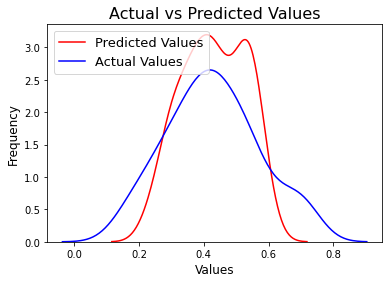

In [481]:
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### E.3) Lasso MLR model: (L1 Regularization)
##### Evaluation with alpha optimization
We've used GridSearch to find the optimal alpha value

In [482]:
# find optimal alpha with grid search
alpha = [0.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)

In [483]:
lasso_mlr = Lasso()
grid = GridSearchCV(estimator=lasso_mlr, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished


In [484]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.3635055588088109
Best Params:  {'alpha': 1e-05}


#### Retrain lasso MLR with optimal value of alpha

In [488]:
lasso_mlr = Lasso(alpha=0.00001)
lasso_mlr.fit(X,y)
y_pred = lasso_mlr.predict(X_test)

In [489]:
#Evaluations
print("***Cross Validation R2 score - Training Data***")
get_cv_scores(lasso_mlr,X,y) #R2 cv on training data

print("***Cross Validation R2 score - Test Data***")
get_cv_scores(lasso_mlr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Training Data***
CV Mean (R2):  0.3635055588088109
STD:  0.058398208176910424


***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.012866662510252569
STD:  0.39073791754852927


***Scores (no cv) on Test Data***
R2: 0.355
MSE: 0.013
MAE: 0.093


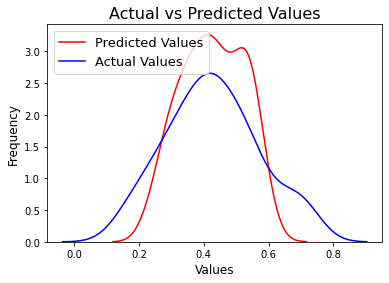

In [490]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### E.4) Ridge MLR model: (L2 Regularization)
#### E.4.1) Evaluation with alpha optimization
We've used GridSearch to find the optimal alpha value

In [491]:
# find optimal alpha with grid search xyz
alpha = [0.00001,0.0001,0.001, 0.01,0.05, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha) 

In [492]:
ridge_mlr = Ridge()
grid = GridSearchCV(estimator=ridge_mlr, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


In [493]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.3642973492226358
Best Params:  {'alpha': 0.1}


#### Retrain ridge MLR with optimal value of alpha

In [494]:
ridge_mlr = Ridge(alpha=0.1)
ridge_mlr.fit(X,y)
y_pred = ridge_mlr.predict(X_test)

In [495]:
#Evaluations
print("***Cross Validation R2 score - Training Data***")
get_cv_scores(ridge_mlr,X,y) #R2 cv on training data

print("***Cross Validation R2 score - Test Data***")
get_cv_scores(ridge_mlr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Training Data***
CV Mean (R2):  0.3642973492226358
STD:  0.05822564869602319


***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.26313559827544913
STD:  0.1971341848830327


***Scores (no cv) on Test Data***
R2: 0.358
MSE: 0.013
MAE: 0.092


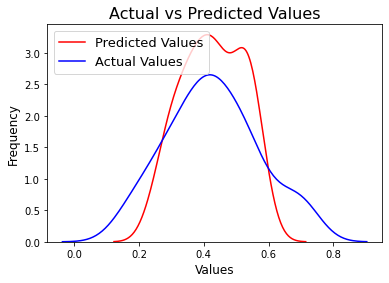

In [496]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)